<a href="https://colab.research.google.com/github/OH1107/edu/blob/master/fintech/20200917_Naver_search_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 데이터랩의 검색어 트렌드의 주가 영향력 분석


## reference (parameters)
- 네이버 디벨로퍼 가입
- 어플리케이션 등록
- https://developers.naver.com/docs/datalab/search/#%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0

In [1]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144600 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# 네이버 데이터랩 API code

- 라이브러리 호출

In [149]:
from pandas.io import gbq

import os
import sys
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

- CJ ENM의 2019년 작품 키워드 설정 (극한직업, 사바하, 걸캅스, 백두산, 나쁜녀석들)
  - '기생충'은 다른 영화들에 비해 데이터랩 검색량이 너무 많아 비교가 어려우므로 키워드에서 제외
- 해당 키워드로 데이터 랩에 검색 가능토록 json 형태로 변환하는 함수 정의

In [150]:
keywords=[['극한직업'],['사바하'],['걸캅스'],['백두산'],['나쁜녀석들']]

def makeQry(keywords=[],sdate='',edate='',tunit='date'):
  res = []
  for word in keywords:
    dict={'groupName':word[0], 'keywords':word}
    res.append(dict)
  

  rdict={"startDate":sdate,
         "endDate":edate,
         "timeUnit":tunit,
         "keywordGroups":res}
  return json.dumps(rdict, ensure_ascii=False)

- json 형태의 키워드를 데이터 랩 API에 대입하는 함수 정의

In [151]:
def Mynsearch(keywords=[],sdate='',edate='',tunit='date'):
  client_id = "GjOIh9f0eos4ZlO0MuPJ"
  client_secret = "6D0DNFKlWz"
  url = "https://openapi.naver.com/v1/datalab/search";
 
  body = makeQry(keywords, sdate, edate, tunit)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if (rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    #print(res)
  else:
    res='error'
    print("Error Code:" + rescode)
  return res

- period 인덱스, 영화제목 컬럼으로 지정한 DataFrame 출력 함수 정의

In [152]:
def MyDataLab(keywords=[],sdate='',edate='',tunit='date'):
  # 네이버 데이터랩 서치
  res=Mynsearch(keywords, sdate, edate, tunit)

  # 데이터 추출을 위한 json
  jdata=json.loads(res)

  # 테이블 머지를 위한 기초테이블
  maindf=pd.DataFrame()

  # 키워드별로 컬럼명 지정
  i =0
  for words in keywords:
    pdata=jdata['results'][i]['data']
    i += 1
    df=pd.DataFrame.from_dict(pdata)
    df.columns=["period",words[0]]
    df.set_index("period", inplace=True)
    maindf=pd.merge(maindf, df, how='outer', left_index=True, right_index=True)

  return maindf

In [153]:
mdf=MyDataLab(keywords, '2019-01-01', '2020-08-30', 'date')
mdf.head()

,극한직업,사바하,걸캅스,백두산,나쁜녀석들
period,,,,,
2019-01-01,0.51273,0.03758,0.01178,0.14547,0.15669
2019-01-02,0.59014,0.03655,0.01355,0.11658,0.14220
2019-01-03,0.57528,0.02870,0.00981,0.10892,0.11350
2019-01-04,5.09767,0.02758,0.01552,0.10172,0.12453
2019-01-05,1.13232,0.03300,0.01299,0.08695,0.14248


- `BigQuery`로부터 주식데이터를 불러내어 데이터 랩 영화 검색량 데이터와 merge시키는 함수 정의

In [191]:
def MyDBLab(keywords=[], sdate='', edate='', tunit='date', Stock_data_location=''):
  # 데이터랩 사용자 정의 함수
  mdf=MyDataLab(keywords, sdate ,edate, tunit)
  
  # 쿼리문에 대입하기 위한 변수 선언
  sdaycode=sdate.replace('-','')
  edaycode=edate.replace('-','')
  
  # BigQuery로 부터 Stock데이터 호출
  project_id = 'groovy-ego-286903'
  sql = "SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL FROM "+Stock_data_location+" WHERE SDAY >="+sdaycode+" and SDAY<="+edaycode+" ORDER BY SDAY asc"
  
  company_df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

  # Stock데이터와 데이터랩 데이터를 merge시키기 위한 index작업
  company_df['period']=[str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in company_df['SDAY']]
  df_stock=company_df.set_index('period')
  
  # 그래프를 호출하기 위해 all_df로 merge
  df=pd.merge(df_stock, mdf, how='outer', left_index=True, right_index=True)

  # 선형보간
  all_df=df.interpolate() 

  return all_df

In [192]:
all_df=MyDBLab(keywords, '2019-01-01', '2020-08-30', 'date', 'Stock_data.cj_stock')

In [185]:
all_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL,극한직업,사바하,걸캅스,백두산,나쁜녀석들
period,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.51273,0.03758,0.01178,0.14547,0.15669
2019-01-02,20190102.0,202700.000000,196500.000000,202900.0,196500.0,58208.000000,0.59014,0.03655,0.01355,0.11658,0.14220
2019-01-03,20190103.0,196700.000000,191200.000000,197500.0,190200.0,69363.000000,0.57528,0.02870,0.00981,0.10892,0.11350
2019-01-04,20190104.0,191200.000000,191500.000000,192500.0,187400.0,70378.000000,5.09767,0.02758,0.01552,0.10172,0.12453
2019-01-05,20190105.0,191666.666667,194133.333333,194800.0,189000.0,68375.333333,1.13232,0.03300,0.01299,0.08695,0.14248


- merge된 데이터를 그래프화 시키는 함수 정의

In [203]:
def pltDBLab(all_df, keywords, xstep=30, ptitle='CJ ENM 영화와 주가의 상관도'):
  xtic=np.arange(0, len(all_df.index), step=xstep)
  xdays=[all_df.index[i] for i in xtic]

  set_df=pd.DataFrame()
  for words in keywords:
    set_df=pd.concat((set_df, all_df[words]), axis=1)


  # X 축을 공유하고 Y 축을 이중으로 사용
  plt.rcParams["figure.figsize"] = (16,8)

  fig, ax1= plt.subplots()

  # 주가 그래프
  ax1.plot(all_df['CLOSEP'], c='k')

  #ax1.axvline(x='2019-01-23',label='극한직업 개봉', c="b", linestyle='--',  linewidth=2)         # 극한직업 개봉일 2019년 1월 23일
  #plt.text(24,240000,"극한직업 개봉")
  #ax1.axvline(x='2019-02-20',label='사바하 개봉',color='orange',linestyle='--',  linewidth=2)    # 사바하 개봉일 2019년 2월 20일
  #plt.text(53,245000,"사바하 개봉")
  #ax1.axvline(x='2019-05-09',label='걸캅스 개봉',color='green',linestyle='--',  linewidth=2)     # 걸캅스 개봉일 2019년 5월 9일
  #plt.text(130,240000,"걸캅스 개봉")
  #ax1.axvline(x='2019-09-11',label='나쁜녀석들 개봉',c='r',linestyle='--',  linewidth=2)         # 나쁜녀석들 개봉일 2019년 9월 11일
  #plt.text(257,240000,"나쁜녀석들 개봉")
  #ax1.axvline(x='2019-12-19',label='백두산 개봉',color='purple',linestyle='--',  linewidth=2)    # 백두산 개봉일 2019년 12월 19일
  #plt.text(355,240000,"백두산 개봉")

  ax1.set_ylabel('Price')
  plt.xticks(xtic, xdays, rotation=45)

  # 네이버 데이터 랩 영화 검색량 그래프
  ax2=ax1.twinx()
  ax2.set_ylabel("Ratio")

  # 그래프 출력, 조정
  set_df.plot(ax=ax2)

  plt.title("CJ ENM 영화와 주가의 상관도", fontdict={'fontsize':20})
  plt.legend()
  plt.tight_layout()
  plt.show()

In [176]:
keywords[0]

['극한직업']

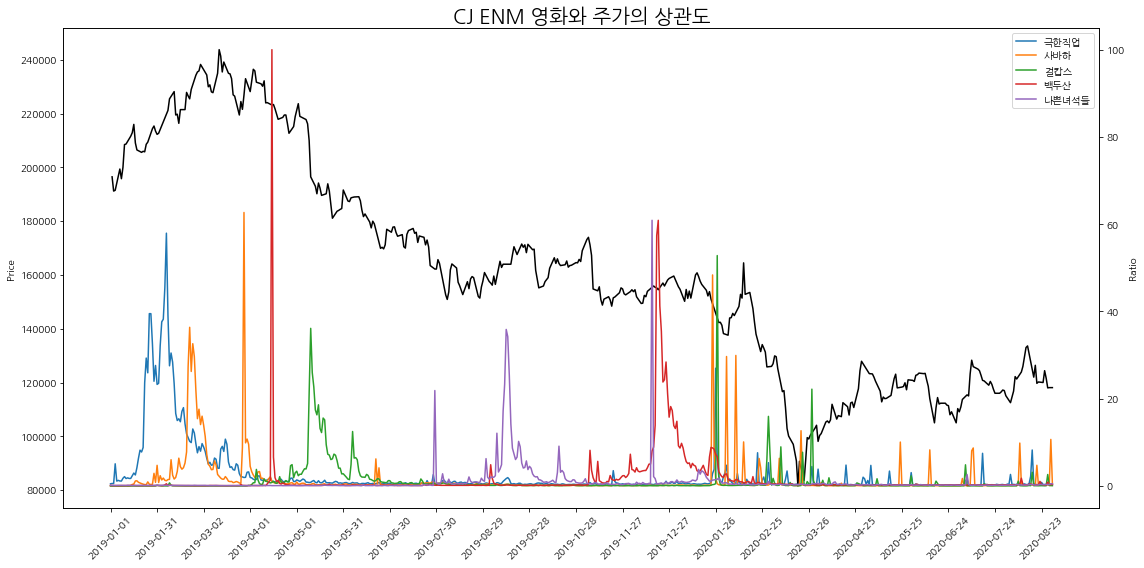

In [204]:
pltDBLab(all_df, keywords, 30, 'CJ ENM 영화와 주가의 상관도')

- 극한직업 영화 개봉가 종가에 영향을 끼치는지에 대한 상관관계 분석

In [182]:
movie1_df=MyDBLab(keywords, '2019-01-01', '2019-02-26', 'date', 'Stock_data.cj_stock')

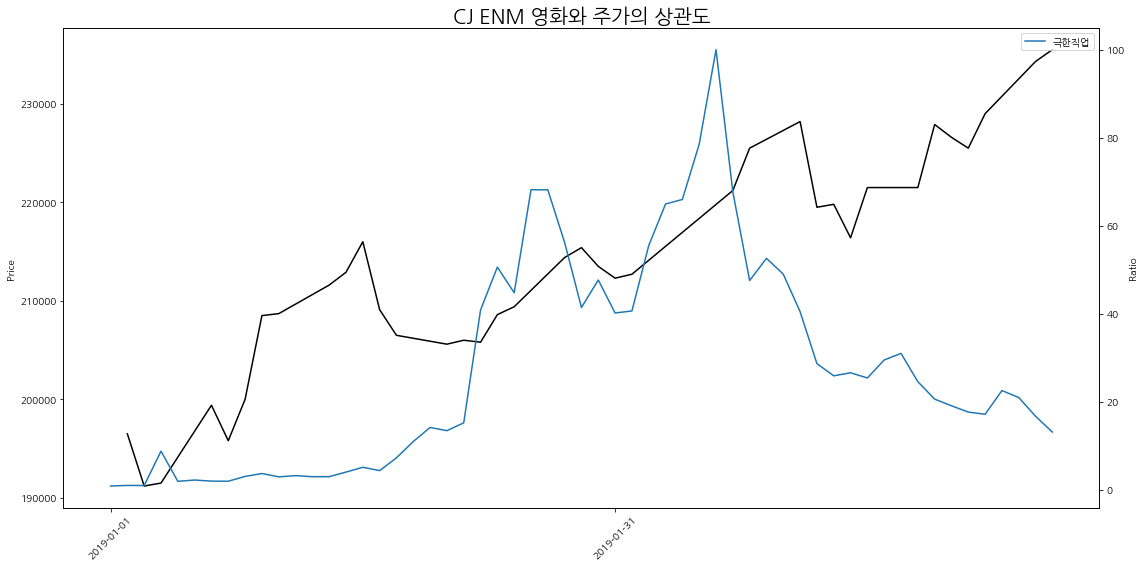

In [184]:
pltDBLab(movie1_df, keywords, 30, 'CJ ENM 영화와 주가의 상관도')

In [168]:
movie1_df[['CLOSEP','극한직업']].corr()

,CLOSEP,극한직업
CLOSEP,1.000000,0.357283
극한직업,0.357283,1.000000
